In [1]:
import pandas as pd
import numpy as np
import talib as ta
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from scipy.signal import argrelextrema, find_peaks_cwt
import json
from bs4 import BeautifulSoup
import requests 
import urllib.request
import datetime
from datetime import timedelta, datetime
import time
from scipy import signal
diretorio= os.getcwd()
diretorio

'/Users/igoracmorais/igor/Wise&Trust/CPM_trading2/Trading/Rotines/Python'

In [19]:
data=pd.read_csv(diretorio+"/btc.csv",sep=";",index_col="datetime")

In [3]:
def cmo(data,overbought=50,oversold=-50,time=[]):
    for cmo in time:
        data["cmo_"+str(cmo)]=ta.CMO(data.close,timeperiod=cmo)
        # sinais
        data["cmo_s"+str(cmo)]=0
        data.loc[(data["cmo_"+str(cmo)]>overbought),"cmo_s"+str(cmo)]=-1
        data.loc[(data["cmo_"+str(cmo)]<oversold),"cmo_s"+str(cmo)]=1
    return data

In [4]:
# Candlestick graph
def candle_graph_cmo(data,nome_coluna_datas="datetime",n=200):
    ohlc=data.reset_index()[-n:]
    ohlc[nome_coluna_datas]=pd.to_datetime(ohlc[nome_coluna_datas])
    ohlc[nome_coluna_datas]=ohlc[nome_coluna_datas].apply(mdates.date2num)
    #
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(6,8)) 
    ax1 = plt.subplot2grid((6,1), (0, 0),rowspan=3)
    ax2 = plt.subplot2grid((6,1), (3, 0),rowspan=2)
    ax1.axes.get_xaxis().set_visible(False)
    candlestick_ohlc(ax1, ohlc.values, width=.6, colorup='green', colordown='red')
    #
    ax2.plot(ohlc[nome_coluna_datas], ohlc["cmo_7"], color = 'green', lw=1,label="cmo_7")
    ax2.plot(ohlc[nome_coluna_datas], ohlc["cmo_14"], color = 'blue', lw=1,label="cmo_14")
    ax2.plot(ohlc[nome_coluna_datas], ohlc["cmo_21"], color = 'black', lw=1,label="cmo_21")
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.ylim(-100,100)
    import matplotlib.ticker as ticker
    ax2.xaxis.set_major_locator(ticker.MaxNLocator(10))
    plt.xticks(fontsize=8)
    ax1.legend(label="closed")
    ax2.legend(loc=1,fontsize=8)
    return plt.show()

In [5]:
def sell_signal(data,coluna=[],widths=np.arange(1,10)):
    for p in coluna:
        peak=signal.find_peaks_cwt(data[p],widths=widths)
        data["peaks"]=data[p].iloc[peak]
    return data, peak

## Exemplo:

In [20]:
df=cmo(data,overbought=50,oversold=-50,time=[7,14,21,28])
print(df.shape)
df.tail(4)

(2001, 13)


,open,high,low,close,volume,cmo_7,cmo_s7,cmo_14,cmo_s14,cmo_21,cmo_s21,cmo_28,cmo_s28
datetime,,,,,,,,,,,,,
2018-10-13,6252.10,6280.73,6238.92,6267.27,1.377050e+08,-42.035030,0,-23.695339,0,-16.112337,0,-12.476428,0
2018-10-14,6267.27,6346.56,6247.17,6277.73,2.154229e+08,-38.944328,0,-22.505803,0,-15.457182,0,-12.048314,0
2018-10-15,6277.73,7234.83,6244.77,6612.36,1.190524e+09,23.326681,0,7.981399,0,2.939184,0,0.514443,0
2018-10-16,6612.69,6612.99,6583.30,6606.12,8.020117e+06,22.135837,0,7.444430,0,2.619038,0,0.296982,0


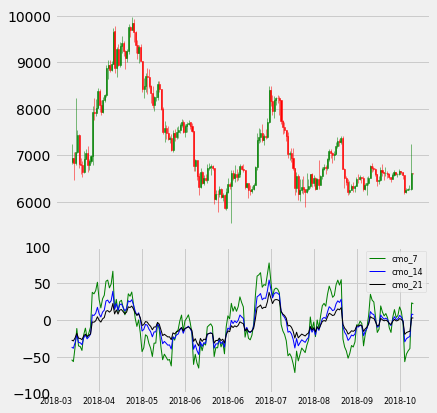

In [7]:
candle_graph_cmo(df)

### Peak example

In [8]:
def peak_graph(data,coluna=[],coluna_peak=[],n=300):
    # coluna: onde os picos são projetados
    # coluna_peak: onde os picos são calculados
    peaks=signal.find_peaks_cwt(data[coluna_peak],np.arange(1,12))
    data["peakss"]=data[coluna].iloc[peaks]
    data2=data[-n:]
    #
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(6,8)) 
    ax1 = plt.subplot2grid((6,1), (0, 0),rowspan=2)
    ax2 = plt.subplot2grid((6,1), (2, 0),rowspan=2)
    ax1.axes.get_xaxis().set_visible(False)
    ax2.axes.get_xaxis().set_visible(False)
    x_axis = data2.index.get_level_values(0)
    ax1.plot(x_axis,data2[coluna],lw=1,color='black')
    ax1.plot(x_axis,data2['peakss'],color='blue',marker="o")
    ax2.plot(x_axis,data2[coluna_peak],color='blue',lw=1,linestyle="--")
    #
    plt.xticks(fontsize=8)
    ax1.legend(loc=1,fontsize=8)
    ax2.legend(loc=1,fontsize=8)
    return plt.show()

/Users/igoracmorais/anaconda3/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:73: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/Users/igoracmorais/anaconda3/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:74: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


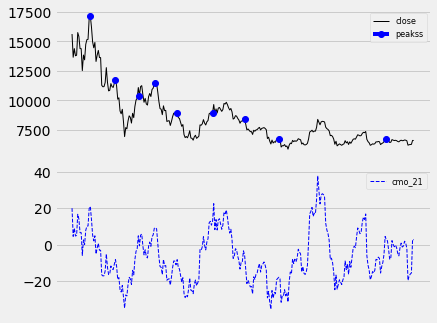

In [9]:
peak_graph(df,coluna="close",coluna_peak="cmo_21")

## Volatility example

In [10]:
def vol(data,n=100,coluna="close",dias=1):
    df0=data[coluna].index.searchsorted(data[coluna].index-pd.Timedelta(days=dias))
    df0=df0[df0>0]
    df0=pd.Series(data[coluna].index[df0-1],index=data[coluna].index[data[coluna].shape[0]-df0.shape[0]:])
    df0=data[coluna].loc[df0.index]/data[coluna].loc[df0.values].values-1
    df0=df0.ewm(span=n).std()
    return df0

In [21]:
df.index

Index(['2013-04-25', '2013-04-26', '2013-04-27', '2013-04-28', '2013-04-29',
       '2013-04-30', '2013-05-01', '2013-05-02', '2013-05-03', '2013-05-04',
       ...
       '2018-10-07', '2018-10-08', '2018-10-09', '2018-10-10', '2018-10-11',
       '2018-10-12', '2018-10-13', '2018-10-14', '2018-10-15', '2018-10-16'],
      dtype='object', name='datetime', length=2001)

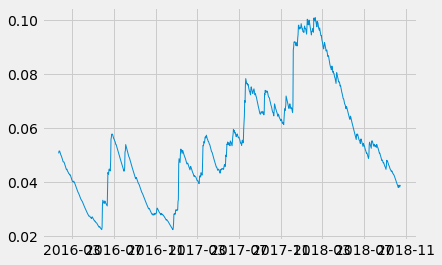

In [27]:
# primeiro passo: converter o indice para datetime
df.index = pd.to_datetime(df.index)
vol_close=vol(df)
plt.plot(vol_close[-1000:],lw=1);

## Triple-Barrier

In [59]:
def applyPtS10nT1(close,events,ptS1,molecule):
    events_=events.loc[molecule]
    out=events_[["t1"]].copy(deep=True)
    if ptS1[0]>0:
        pt=ptS1[0]*events_['trgt']
    else:
        pt=pd.Series(index=events.index)
    if ptS1[1]>0:
        s1=-ptS1[1]*events_["trgt"]
    else:
        s1=pd.Series(index=events.index)
    for loc,t1 in events_["t1"].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1]
        df0=(df0/close[loc]-1)*events_.at[loc,'side']
        out.loc[loc,"s1"]=df0[df0<s1[loc]].index.min()   #earliest stop-loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min()   #earliest profit taking
    return out

In [69]:
df["t1"]=np.nan
datetime="2018-10-16"
df.loc[df.index==datetime,"t1"]=pd.to_datetime(datetime)
df["trgt"]=0
df.loc[df.index>="2018-10-10","trgt"]=4
events=pd.DataFrame(df[["t1","trgt"]])
ptS1=[1,1]
molecule=pd.to_datetime(["2018-10-01","2018-10-10"])
side=pd.Series(1.,index=events.trgt.index)
events=pd.concat([events,side])
events.columns=["t1","trgt","side"]
df.tail(8)

,open,high,low,close,volume,cmo_7,cmo_s7,cmo_14,cmo_s14,cmo_21,cmo_s21,cmo_28,cmo_s28,t1,trgt
datetime,,,,,,,,,,,,,,,
2018-10-09,6650.07,6657.00,6589.39,6631.79,2.139767e+08,11.710262,0,4.203695,0,0.879272,0,-0.816358,0,NaN,0
2018-10-10,6631.79,6633.22,6487.86,6581.07,3.236650e+08,-4.239416,0,-1.187982,0,-1.985887,0,-2.667104,0,NaN,4
2018-10-11,6581.07,6581.59,6171.95,6209.47,6.549241e+08,-56.872368,1,-29.833266,0,-19.561038,0,-14.752944,0,NaN,4
2018-10-12,6209.47,6296.56,6173.86,6250.85,2.898401e+08,-46.417344,0,-25.471252,0,-17.105804,0,-13.130735,0,NaN,4
2018-10-13,6252.10,6280.73,6238.92,6267.27,1.377050e+08,-42.035030,0,-23.695339,0,-16.112337,0,-12.476428,0,NaN,4
2018-10-14,6267.27,6346.56,6247.17,6277.73,2.154229e+08,-38.944328,0,-22.505803,0,-15.457182,0,-12.048314,0,NaN,4
2018-10-15,6277.73,7234.83,6244.77,6612.36,1.190524e+09,23.326681,0,7.981399,0,2.939184,0,0.514443,0,NaN,4
2018-10-16,6612.69,6612.99,6583.30,6606.12,8.020117e+06,22.135837,0,7.444430,0,2.619038,0,0.296982,0,2018-10-16 00:00:00,4


In [ ]:
applyPtS10nT1(df.close,events,ptS1,molecule)